# XTERN Data Science: VelocityX Case Study
By: Peter Liu

This analysis will focus on user trends in respect to virtual merchandise purchases. Given the data, I define 3 groups: 
- non-purchasers with zero purchases,
- low-purchasers with one to three purchases, and
- high-purchasers with four to six purchases.

Customer conversion is an important component of any virtual marketplace: how do we turn visitors to the store into purchasers of merchandise?
Accordingly, I focus on the question:
- How can we turn non-purchasers into low-purchasers? In other words, **how do we get users to buy their first piece of merchandise?**

I find that subgroups of non-purchasing users tend to have:
- less time spent on Live360
- less sponsorship interactions (ad clicks)
- less predictive accuracy in challenges
- less chat activity

compared to low-purchasing users. 

To offer users incentives to close these gaps, I propose:

**Live360 Real-Time Chat Challenges** that incentivize users to pay closer attention to Live360 footage and chat activity and offer opportunities to improve average predictive accuracy.

Although a careful forecasting of the quantitative effects of this proposed feature is difficult without further research, I find that according to my model built on user data, **spending just 20 extra minutes on Live360 and increasing chat activity by 2 resulted in 35% of non-purchasers being newly classified as low-purchasers**, suggesting that this solution could result in positive customer conversion.

## 1. Cleaning Data

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [184]:
#import data and create initial dataframe
path = "data/2025-VeloCityX-Expanded-Fan-Engagement-Data.csv"
fan_df = pd.read_csv(path)
fan_df.head()

,User ID,Fan Challenges Completed,Predictive Accuracy (%),Virtual Merchandise Purchases,Sponsorship Interactions (Ad Clicks),Time on Live 360 (mins),Real-Time Chat Activity (Messages Sent)
0,U001,5,80,3,10,120,20
1,U002,8,60,1,8,100,35
2,U003,3,90,0,6,90,5
3,U004,7,70,2,15,140,40
4,U005,2,50,5,3,60,8


In [185]:
# search for any null entries (appears there are none)
fan_df.isna().any()

User ID                                    False
Fan Challenges Completed                   False
Predictive Accuracy (%)                    False
Virtual Merchandise Purchases              False
Sponsorship Interactions (Ad Clicks)       False
Time on Live 360 (mins)                    False
Real-Time Chat Activity (Messages Sent)    False
dtype: bool

In [186]:
# drop User ID, can refer to index in pandas dataframe if needed 
fan_df = fan_df.drop(columns="User ID") 

# rename column names to aliases that are easier typed
# Fan Challenges Completed -> challenges_completed
# Predictive Accuracy (%) -> pred_accuracy
# Virtual Merchandises Purchases -> merch_purchases
# Sponsorship Interactions (Ad Clicks) -> spons_interactions
# Time on Live 360 (mins) -> time_live
# Real-Time Chat Activity (Messages Sent) -> chat_activity

fan_df = fan_df.rename({
               "Fan Challenges Completed":"challenges_completed", 
               "Predictive Accuracy (%)":"pred_accuracy", 
               "Virtual Merchandise Purchases":"merch_purchases", 
               "Sponsorship Interactions (Ad Clicks)":"spons_interactions", 
               "Time on Live 360 (mins)":"time_live", 
               "Real-Time Chat Activity (Messages Sent)":"chat_activity"}, 
              axis="columns", errors="raise")

In [187]:
# Data validation
# relatively small dataset, so can examine distinct values of each column to ensure that there are no out-of-place values
# for instance, pred_accuracy should not display any negative values or values greater than 100
# there should be no negative or decimal values for merch_purchases or challenges_completed, etc.
for i in range(0, 6):
    print(fan_df.columns[i])
    print(fan_df.iloc[:,i].unique())

challenges_completed
[ 5  8  3  7  2 10  6  9  4  1]
pred_accuracy
[80 60 90 70 50 85 75 95 65 55 84 82 54 91 88 77 56 58 57 61 83 97 72 73
 86 93 89 71 76 96 63 52 64 62 81 98 53 79 94 92 78 51 69 74]
merch_purchases
[3 1 0 2 5 6 4]
spons_interactions
[10  8  6 15  3 12  5  9  2  4 16  1  0 11 18 19  7 17 13 14]
time_live
[120 100  90 140  60 180 130 150  80  95 163 196 102  98  85 158 109  72
 119 194 116  79 124  67 174 151 157 125  91 145 110 122 184 117 108 129
  74 113 160 112 167  64 162  65 168 175 153 106 114 111 173 183 165 179
  78 149 176 121  82 186 199 188 181  93 155 185 177 107 148  75 128  81
 152 135  88 144 159  92]
chat_activity
[20 35  5 40  8 25 15 45 10  6  9  4 33 30 18 31  0 44  3 23  1 48 27 26
 19 11 49 34 32 42 36  2 39 43 28 12 22 16  7 24 47 17 38 29]


With that, the data should be ready for analysis.

## 2. Exploratory Analysis and Glancing for Trends

Here, summary statistics are generated for each attribute of the data, and each variable is plotted against one another to discover any univariate trends.

In [188]:
for i in range(0, 6):
    print("Summary statistics for", fan_df.columns[i])
    print(fan_df.iloc[:,i].describe())

Summary statistics for challenges_completed
count    100.000000
mean       5.790000
std        2.825908
min        1.000000
25%        3.000000
50%        6.000000
75%        8.000000
max       10.000000
Name: challenges_completed, dtype: float64
Summary statistics for pred_accuracy
count    100.000000
mean      74.990000
std       14.033506
min       50.000000
25%       62.000000
50%       77.000000
75%       86.500000
max       98.000000
Name: pred_accuracy, dtype: float64
Summary statistics for merch_purchases
count    100.000000
mean       2.670000
std        2.064882
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max        6.000000
Name: merch_purchases, dtype: float64
Summary statistics for spons_interactions
count    100.000000
mean       8.680000
std        6.340315
min        0.000000
25%        2.000000
50%        8.000000
75%       15.000000
max       19.000000
Name: spons_interactions, dtype: float64
Summary statistics for time_live
count  

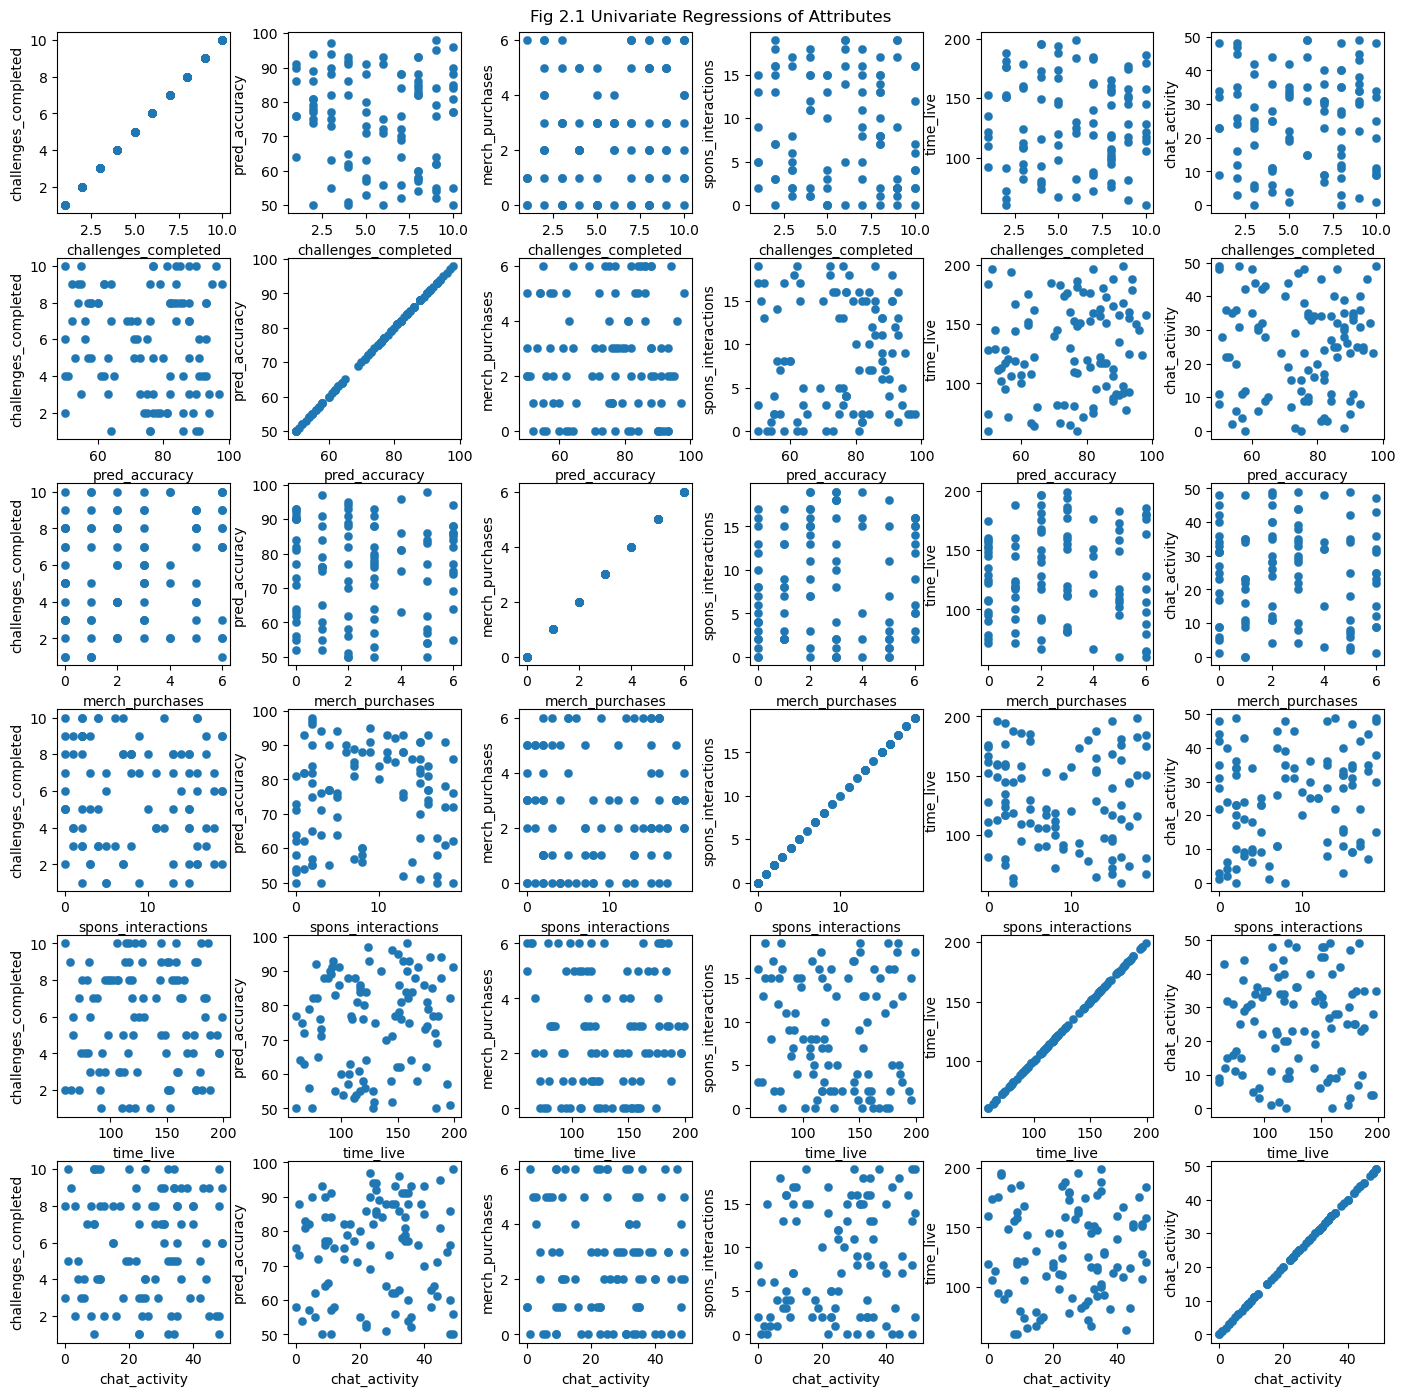

In [189]:
# attempt to find if any one of the variables may be a good predictor for another variable.
fig, ax = plt.subplots(6, 6)
fig.set_size_inches(14, 14)
plt.suptitle(t="Fig 2.1 Univariate Regressions of Attributes")
fig.tight_layout()
for i in range(0, 6):
    for j in range(0, 6):
        ax[i][j].scatter(fan_df.iloc[:,i], fan_df.iloc[:,j], linewidths=.2)
        ax[i][j].set_xlabel(fan_df.columns[i])
        ax[i][j].set_ylabel(fan_df.columns[j])

Excluding the plots where the variables are being plotted against themselves, there are not many distinct trendlines expressed in the plots. 

Notably, plotting pred_accuracy against spons_interactions creates a graph (4th row from top, 2nd column from left) that looks like it could be fitted with a quadratic curve. Somehow, the data show that predictive accuracy peaks around the point users reach 10 sponsorship interactions. Perhaps further work is required to unravel any potential implications that this trend has. 

However, this analysis will focus on user behavior regarding merchandise purchasing, so this will be set aside for a potential future analysis.

## 3. Analyzing Virtual Merchandise Purchase Groups 

In this section, I will:
- split users into groups based on their purchasing amounts
- determine how the game might be able to influence non-purchasers to make their first purchase, based on behavioral differences between non-purchasers and those who have purchased a small amount of merchandise.

(array([20., 14., 17., 17.,  6., 12., 14.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

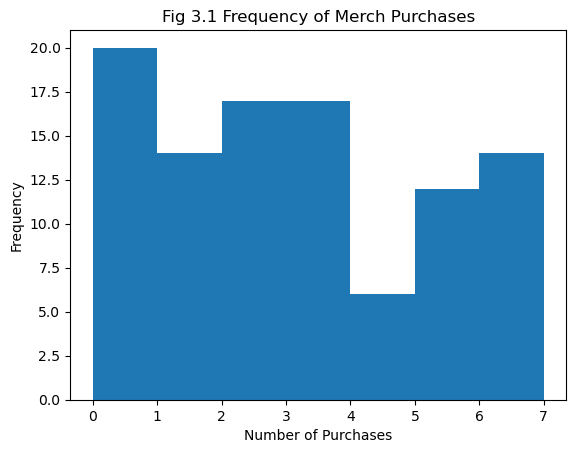

In [190]:
# virtual merchandise as a dependent variable 
plt.title(label="Fig 3.1 Frequency of Merch Purchases")
plt.ylabel("Frequency")
plt.xlabel("Number of Purchases")
plt.hist(fan_df['merch_purchases'], bins=np.arange(0, fan_df['merch_purchases'].max() + 2))

We observe: 
- a peak bar at 0 purchases
- a drop to 1 purchase and a smaller peak to 2-3 purchases
- a sharp drop for 4 purchases and a rise in 5-6 purchases, but values are not as frequent as 2-3 purchases

With this, define 3 purchase classes:
- Non-purchasers ("non_p") with 0 purchases
- Low-purchasers ("low_p") with 1-3 purchases
- High-purchasers ("high_p") with 4-6 purchases

In [191]:
# implement purchase classes, drop merch_purchases column
purchase_df = fan_df.copy()
purchase_df.insert(0, "purchase_class", [lambda x:"na" for x in range(0, 100)])
purchase_df["purchase_class"] = ["non_p" if x == 0 else "high_p" if x >= 4 else "low_p" for x in purchase_df['merch_purchases']]
purchase_df = purchase_df.drop(columns="merch_purchases")
purchase_df.head()

,purchase_class,challenges_completed,pred_accuracy,spons_interactions,time_live,chat_activity
0,low_p,5,80,10,120,20
1,low_p,8,60,8,100,35
2,non_p,3,90,6,90,5
3,low_p,7,70,15,140,40
4,high_p,2,50,3,60,8


To observe differences in attributes between these newly-implemented purchasing classes, create boxplots:

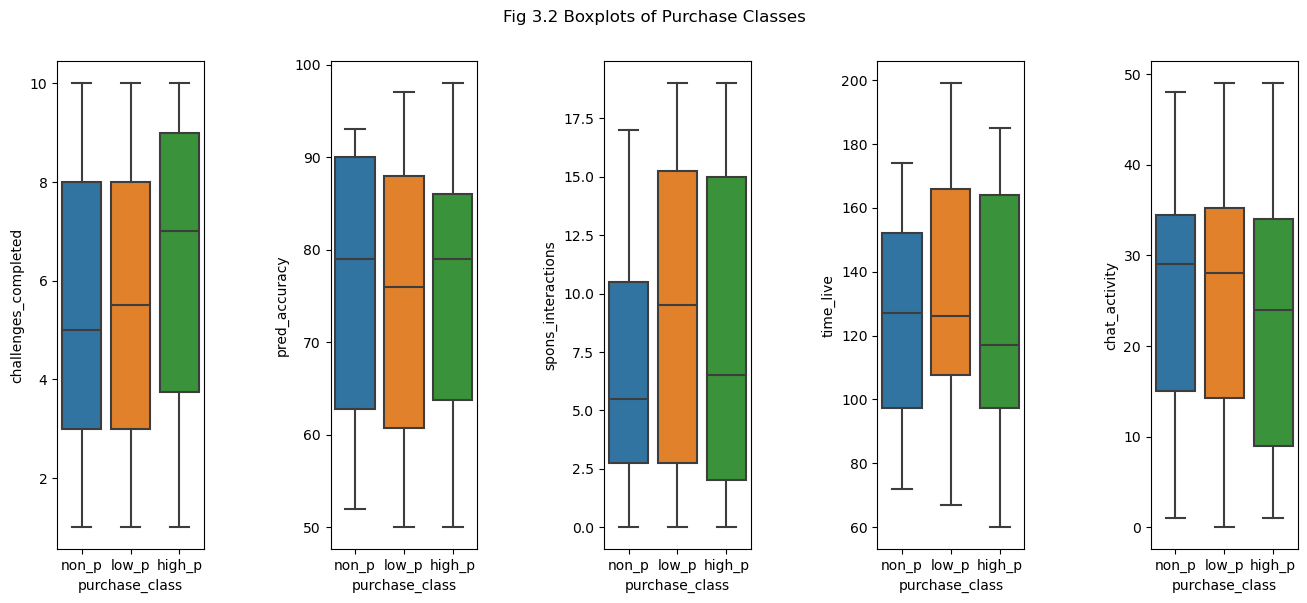

In [192]:
fig, ax = plt.subplots(1, 5)
plt.suptitle(t= "Fig 3.2 Boxplots of Purchase Classes")
fig.tight_layout()
fig.set_size_inches(14, 6)
for i in range(0, 5):
    sns.boxplot(data=purchase_df, x="purchase_class", y=purchase_df.iloc[:,i+1], order=['non_p', 'low_p', 'high_p'], ax=ax[i])

### Comparing non-purchasers to low-purchasers
- Non-p and low-p have a similar distribution of completed challenges, with the low-p median amount of completed challenges slightly greater.
- Low-p has a greater range of prediction accuracy, but consistently slightly lower prediction acuracy than non-p.
- Low-p has a greater range and consistently larger number of sponsorship interactions than non-p.
- Low-p has a greater range of time spent on Live360, with a similar median but higher upper and lower quartiles than non-p.
- Low-p has a similar distribution of chat activity to non-p, being only spread slightly wider and with a slightly lower median.

A decision tree classifier offers ease of interpretability, which is desirable in this case. We are not trying to classify new users at this point in time, but we are trying to figure out what characteristics one class has that another does not.

Perhaps training a tree to categorize all three classes at once is not necessary: a non-purchaser is not converted into a high-purchaser without first becoming a low-purchaser. Decreasing the scope of the classification problem to focus on the differences between just two classes will help us determine how to move one user from one class to the next. 

In [193]:
# examine decision boundaries between non-purchasers and low-purchasers
low_purchase_df = purchase_df[purchase_df["purchase_class"] != "high_p"]
low_purchase_df

,purchase_class,challenges_completed,pred_accuracy,spons_interactions,time_live,chat_activity
0,low_p,5,80,10,120,20
1,low_p,8,60,8,100,35
2,non_p,3,90,6,90,5
3,low_p,7,70,15,140,40
7,low_p,9,95,9,150,45
...,...,...,...,...,...,...
94,low_p,8,58,17,144,12
96,low_p,3,82,1,159,24
97,low_p,1,91,9,92,34
98,non_p,8,93,1,160,40


For cohesiveness, create a boxplot comparing only non-purchasers and low-purchasers:

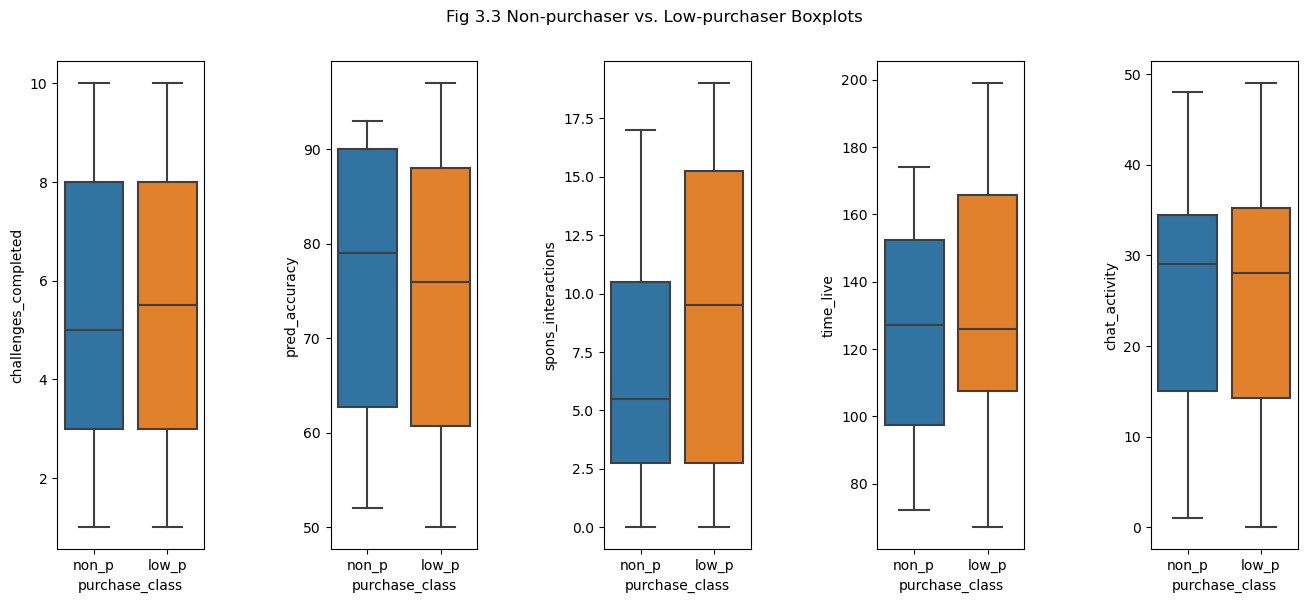

In [194]:
fig, ax = plt.subplots(1, 5)
plt.suptitle(t="Fig 3.3 Non-purchaser vs. Low-purchaser Boxplots")
fig.tight_layout()
fig.set_size_inches(14, 6)
for i in range(0, 5):
    sns.boxplot(data=low_purchase_df, x="purchase_class", y=low_purchase_df.iloc[:,i+1], order=['non_p', 'low_p'], ax=ax[i])

In [197]:
# create and train decision tree
model = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=5)
X = low_purchase_df.iloc[:,1:]
y = low_purchase_df.iloc[:,0]
model.fit(X, y)

# implement 5-fold CV to evaluate prediction accuracy
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.64285714, 0.42857143, 0.5       , 0.61538462, 0.69230769])

This model may not be necessarily very accurate in distinguishing between the two classes, but also is not incredibly inaccurate, with a 0.5 to 0.7 range of accuracy.

Visualize the decision tree and interpret its rules:

Text(0.5, 1.0, 'Fig 3.4 Non-purchaser and Low-purchaser Decision Tree')

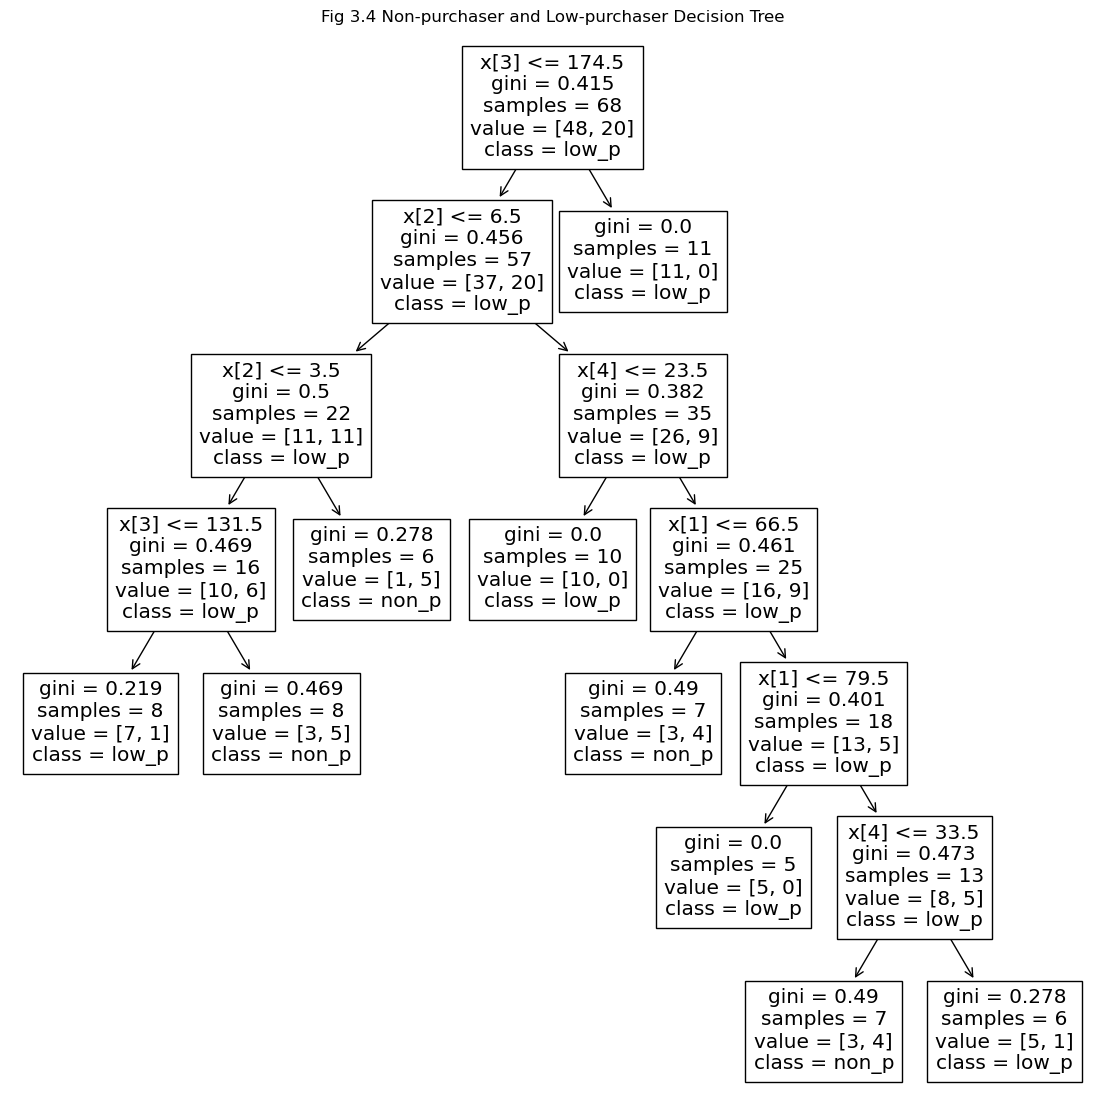

In [198]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(14, 14)
tree.plot_tree(model, class_names=["low_p", "non_p"], ax=ax)
plt.title(label="Fig 3.4 Non-purchaser and Low-purchaser Decision Tree")

Although the decision tree algorithm is greedy and may not mark the most optimal boundaries for setting these groups apart, by interpreting the rules present at each node split, we observe that the decision tree distinguishes non-p from low-p with the following rules:

non-purchasers have less than 174.5 minutes of Live360 time AND:
- a) have less than or equal to 3.5 sponsorship interactions, AND less than or equal to 131.5 minutes spent on Live360
- OR:
- b) have greater than 3.5 and up to 6.5 sponsorship interactions, AND:
  - i) have less than or equal to 66.5 predictive accuracy
  - OR:
  - ii) have greater than 79.5 predictive accuracy AND less than 33.5 chat activity.
 
To sum this up, non-purchasers are therefore generally characterized by lower usage time of Live360, and then additionally:
- 0-3 sponsorship interactions and (again) lower usage time of Live360.
- 4-6 sponsorship interactions, and lower predictive accuracy.
- 4-6 sponsorship interactions, and lower chat activity.

## 3. Turning non-purchasers into low-purchasers

Now that we know what boundaries seem to characterize non-purchasing users, we can explore implementing features that bridge these gaps, resulting in one or more of: 

- increased sponsorship interactions
- increased time spent on Live360
- increased predictive accuracy
- increased chat activity

in non-purchasing users.

### Proposal: Real-Time Chat Challenges
Raising Live360 time, chat activity, chances at improving predictive accuracy
- Offering frequent, low-stakes, low-rewards challenges in the form of polls and questions that pop up in chat can increase chat activity and strengthen connections among users as they are incentivized to pay attention to the discussion at hand.
- These real-time challenges would be based on identifying events that just occurred in Live360 or predicting events a few minutes into the future, incentivizing users to engage in more Live360 screentime.
- Users get more comfortable participating in these high-frequency, low-risk challenges that can raise their average predictive accuracy
- Increased time spent in chat rooms and Live360 increases user exposure time to ads placed there, potentially increasing sponsorship interactions.

It may be hard to predict exactly how this will quantitatively affect the non-purchasing class, but we can examine how our model will predict their purchase level based on just 20 more minutes of time spent on Live360 and a bit more chat interactions:

In [199]:
# create a new dataframe for predictions, using only non-purchasers.
# add 20 minutes of live time and 2 minutes of chat activity to each observation
pred_purchase_df = low_purchase_df[low_purchase_df["purchase_class"] == "non_p"].copy()
pred_purchase_df[["time_live"]] += 20
pred_purchase_df[["chat_activity"]] += 2
pred_purchase_df.count()

purchase_class          20
challenges_completed    20
pred_accuracy           20
spons_interactions      20
time_live               20
chat_activity           20
dtype: int64

There are 20 initially-designated non-purchasers. 

In [200]:
# predict how many of these non-purchasers remain as non-purchasers after additional time
predict_list = pd.Series(model.predict(pred_purchase_df.iloc[:,1:]))
predict_list[predict_list == 'non_p'].count()

13

7 of 20, or 35%, of non-purchasers are now classified as low-purchasers with the additional time, suggesting that the increased Live360 and chat time could influence users to make their first purchases.